# Building Explainable Machine Learning Models
## Exercise: Partial Dependence Plot(PDP) & Individual Conditional Expectation(ICE) Plots





Feature Importance gives us the features that affect the predicions, the partial dependence plots on the other hand, tell us how a feature affects the predictions. PDPs can analyze the interaction between the target and the input feature of interest, while marginalizing all the other input features [1]. In other words. what happens to the target when one of the feature changes but all other variables are held constant. 


<div class="alert alert-block alert-info">

* [1]PDPs were introduced in the context of gradient boosting machines (GBM) by Friedman (2000)- Friedman, Jerome H. [“Greedy Function Approximation: A Gradient Boosting Machine.”](https://projecteuclid.org/journals/annals-of-statistics/volume-29/issue-5/Greedy-function-approximation-A-gradient-boostingmachine/10.1214/aos/1013203451.full) Annals of Statistics 29: 1189–1232.
    
* Partial Dependence is calculated after a model has been fitted. So, let’s train and fit a Random Forest Classifier model on the training data.
    
* Also make sure that the model has a good predictive performance or in other words you have trained a good model before inspecting the importance of its features. There is no point in investigating a bad model.
    </div>



During this exercise, you are going to be working with the Partial Dependence Plots(PDPs) on a preprocessed version of the [Adult Income Dataset ](https://archive.ics.uci.edu/ml/datasets/adult) using scikit-learn. You'll perform the following steps:

1. Import and preprocess the dataset
2. Train a Random Forest classifier on the data.
3. Compute and plot one and two dimensional PDPs.
4. Explain the results


Let's get started!

---

## Case Study

### Predicting if income exceeds $50,000 per year based on 1994 US Census Data 

 The Adult Income dataset, also known as the "Census Income" dataset, contains a variety of attributes or features that describe individuals in the dataset. The target variable is True if a person earns more than `$50K` annually and False if the earned income is ≤ $50K. The attributes of our dataset (preprocessed version) include:

* **Age** : the age of the individual
* **Workclass** : the type of employment the individual has (e.g. private, government, self-employed)
* **Education** : the level of education the individual has achieved (e.g. high school, college, graduate degree)
* **Marital-status** : the individual's marital status (e.g. married, divorced, single)
* **Occupation** : the type of work the individual is employed in (e.g. sales, management, craft-repair)
* **Race** : the individual's race (e.g. White, Black, Asian)
* **Sex** : the individual's gender (e.g. Male, Female)
* **Hours-per-week** : the number of hours the individual works per week
* **Income** : the individual's income level (either <=50K or >50K)


<div class="alert alert-block alert-danger">


Note that the attributes might be different based on the source of the dataset and the version you are using. Also this dataset reflects bias and imbalance w.r.t gender and race. Be careful when using such datasets. In this notebook this dataset is only used for demo purposes.

## Importing Necessary Libraries

Let’s start by importing the necessary libraries.

In [35]:
import numpy as np   
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline

np.random.seed(123) #ensure reproducibility

import warnings  
warnings.filterwarnings("ignore")

In [36]:
# setting up the styling for the plots in this notebook
sns.set(style="white", palette="colorblind", font_scale=0.8, 
        rc={"figure.figsize":(10,8)})

##  Reading in the Dataset

Let’s read in the data and look at the first few rows



In [37]:
data= pd.read_csv('../data/Adult Income Dataset.csv')
data.head()

,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,28,Private,Bachelors,Single,White-Collar,White,Female,60,0
1,30,Self-Employed,Assoc,Married,Professional,White,Male,65,1
2,32,Private,Some-college,Married,White-Collar,White,Male,50,0
3,20,Private,Some-college,Single,Service,White,Female,35,0
4,41,Self-Employed,Some-college,Married,White-Collar,White,Male,50,0


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26048 entries, 0 to 26047
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             26048 non-null  int64 
 1   workclass       26048 non-null  object
 2   education       26048 non-null  object
 3   marital_status  26048 non-null  object
 4   occupation      26048 non-null  object
 5   race            26048 non-null  object
 6   gender          26048 non-null  object
 7   hours_per_week  26048 non-null  int64 
 8   income          26048 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 1.8+ MB


There are no missing values and no string columns in the given dataset.

In [39]:
# Inspecting Distribution of Target Variable

data['income'].value_counts()

0    19820
1     6228
Name: income, dtype: int64



## Data Preparation 







### Train/Test Split
Splitting the dataset into traininga and validation dataset.

In [40]:
# Creating the target and the features column and splitting the dataset into test and train set.
  
X = data.iloc[:, :-1]  
y = data.iloc[:, -1]  
  
# splitting the dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)



## Encoding the categorical features

We'll leave the numerical features as-is and only encode the categorical features using a OrdinalEncoder.

In [41]:
numerical_features = [
    "age",
    "hours_per_week",
]
categorical_features = X_train.columns.drop(numerical_features)

In [42]:
categorical_features

Index(['workclass', 'education', 'marital_status', 'occupation', 'race',
       'gender'],
      dtype='object')

In [43]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(), categorical_features),
        ("num", "passthrough", numerical_features),
    ],
    sparse_threshold=1,
    verbose_feature_names_out=False,
).set_output(transform="pandas")
preprocessor

ColumnTransformer(sparse_threshold=1,
                  transformers=[('cat', OrdinalEncoder(),
                                 Index(['workclass', 'education', 'marital_status', 'occupation', 'race',
       'gender'],
      dtype='object')),
                                ('num', 'passthrough',
                                 ['age', 'hours_per_week'])],
                  verbose_feature_names_out=False)

## Training the classifier

Now you will fit a [Random Forest classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and compute the [AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html) achieved:

In [44]:
# Training and fitting a Random Forest Model

model = make_pipeline(
    preprocessor,
    RandomForestClassifier(n_estimators=100,max_depth=5,random_state=0)
)
model.fit(X_train, y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(sparse_threshold=1,
                                   transformers=[('cat', OrdinalEncoder(),
                                                  Index(['workclass', 'education', 'marital_status', 'occupation', 'race',
       'gender'],
      dtype='object')),
                                                 ('num', 'passthrough',
                                                  ['age', 'hours_per_week'])],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, random_state=0))])

In [45]:
model.score(X_test, y_test)

0.8057432432432432

We now have our model and our predictions. Let’s now explore the different ways by which we can understand the model and its predictions in a more meaningful way. 

---

## Calculating Partial Dependence plots

Partial Dependence plots are calculated as follows:

* Train a model
* Set all the values for the `feature of interest` to a particluar value without touching any other variables.
* Make predictions on the modified dataset using the previously trained model
* Average over all the predictions. 
* Repeat for all the different values of the `feature of interest`.



The `sklearn.inspection` module provides a convenience function `plot_partial_dependence` to create one-way and two-way partial dependence plots. 


## Plotting 1D PDPs

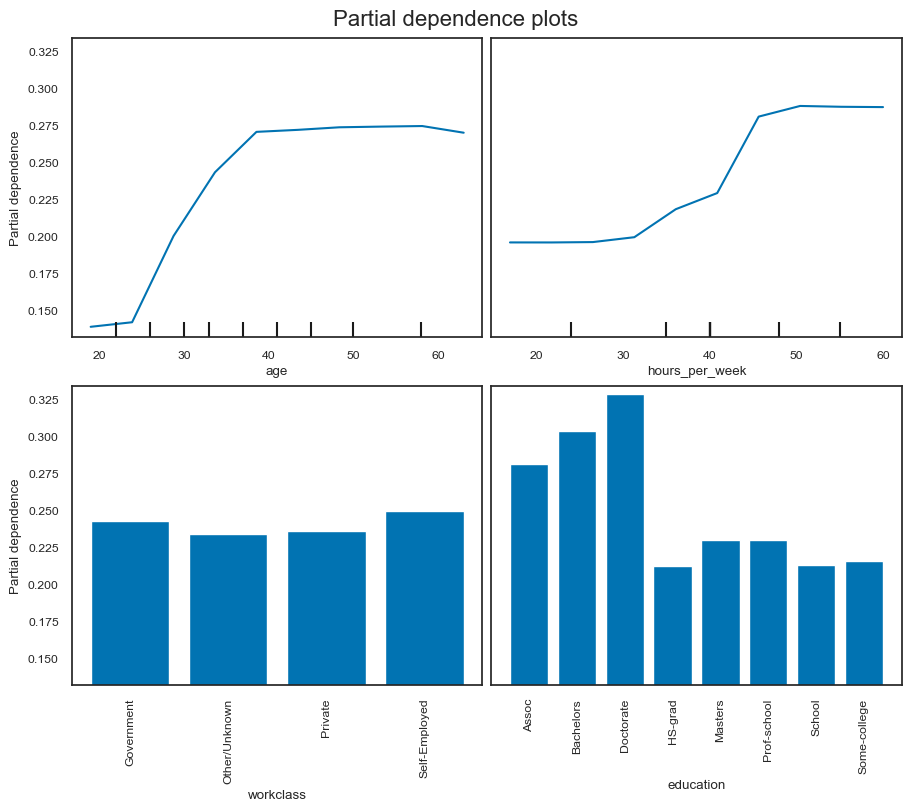

In [46]:
from sklearn.inspection import PartialDependenceDisplay
common_params = {
    "subsample": 50,
    "grid_resolution": 10,
    "random_state": 0,
}


features_info = {
    # features of interest
    "features": ["age", "hours_per_week", "workclass", "education"],
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    "categorical_features":categorical_features,
}

_, ax = plt.subplots(ncols=2, nrows=2, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)

_ = display.figure_.suptitle(
    "Partial dependence plots",
    fontsize=16,
)

## ICE Plots

Partial dependence plots show the average effect of the features of interest while [Individual Conditional Expectation](https://arxiv.org/abs/1309.6392) plots visualize the dependence of the prediction on a feature for each sample separately, with one line per sample.

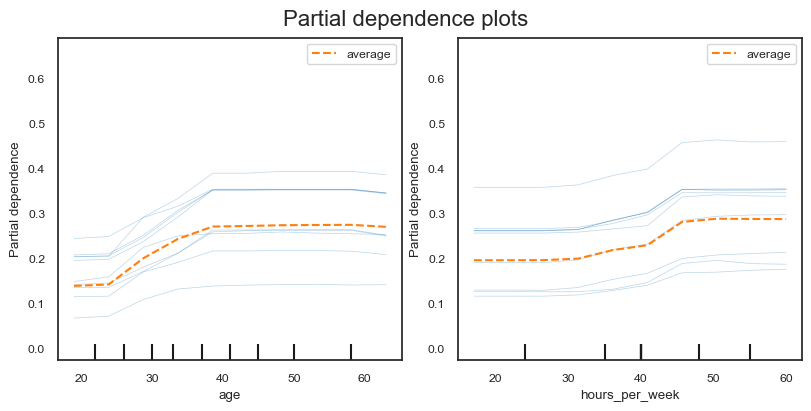

In [48]:
common_params = {
    "subsample": 10,
    "grid_resolution": 10,
    "random_state": 0,
}


features_info = {
    # features of interest
    "features": ["age", "hours_per_week"],
    # type of partial dependence plot
    "kind": "both",
}

_, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 4), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)

_ = display.figure_.suptitle(
    "Partial dependence plots",
    fontsize=16,
)

### References

[1] https://scikit-learn.org/stable/modules/partial_dependence.html

[2] T. Hastie, R. Tibshirani and J. Friedman, [The Elements of Statistical Learning](https://web.stanford.edu/~hastie/ElemStatLearn), Second Edition, Section 10.13.2, Springer, 2009.

[3] C. Molnar, [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book), Section 5.1, 2019.

[4] A. Goldstein, A. Kapelner, J. Bleich, and E. Pitkin, [Peeking Inside the Black Box: Visualizing Statistical Learning With Plots of Individual Conditional Expectation](https://arxiv.org/abs/1309.6392), Journal of Computational and Graphical Statistics, 24(1): 44-65, Springer, 2015.

---